In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
import os 
sys.path.append(os.path.abspath('../'))
import torch
from time import time
from tqdm import tqdm
import drjit as dr
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
import functorch


from convolutions import *
from utils_fns import *
from utils_general import update_sigma_linear, run_scheduler_step, plt_errors, show_with_error
from optimizations import *
from utils_optim import run_optimization, run_grad_optimization, run_cg_optimization, run_bfgs_optimization
from utils_general import run_scheduler_step
from utils_mitsuba import get_mts_rendering, render_smooth, get_mts_rendering_mts
from read_scenes import create_scene_from_xml

if torch.cuda.is_available():
    device = 'cuda'
    print("is available")
    mi.set_variant('cuda_ad_rgb')

is available


# Setup rendering

In [3]:
def apply_rotation(rotation, p, mat_id, init_vpos, factor=20):
    if isinstance(rotation, torch.Tensor):
        if rotation.dim() < 1:
            rotation = rotation.unsqueeze(0)
        rotation = rotation.tolist()[0]

    rot = mi.Transform4f.rotate([0, 1, 0], rotation * factor)
    p[mat_id] = dr.ravel(rot @ init_vpos)
    p.update()
    
def apply_rotation_mts(rotation, p, mat_id, init_vpos, factor=20):
    rot = mi.Transform4f.rotate([0, 1, 0], rotation * factor)
    p[mat_id] = dr.ravel(rot @ init_vpos)
    p.update()

def apply_color(color, p, mat_id, **kwargs):
    if isinstance(color, torch.Tensor):
        color = color.squeeze().tolist()
    p[mat_id] = mi.Color3f(color[0], color[1], color[2])
    p.update()

def setup_coffecup_scene(hparams):
    xmlpath = '../scenes/coffee_mug/classic-mug-backdrop-camMoreFrontal.xml'
    scene = create_scene_from_xml(xmlpath, resx=hparams['resx'], resy=hparams['resy'], integrator=hparams['integrator'],
                                  maxdepth=hparams['max_depth'], reparam_max_depth=hparams['reparam_max_depth'])
    params = mi.traverse(scene)
    mat_pos_id = 'PLYMesh_1.vertex_positions' # rotation
    mat_color_id = 'mat-Mug.brdf_0.reflectance.value' # color
    initial_vertex_positions = dr.unravel(mi.Point3f, params[mat_pos_id])
    # mat_id = mat_color_id
    mat_id = mat_pos_id
    return scene, params, mat_id, initial_vertex_positions

def image_for_plotting(img):
    '''
    plot given torch tensor as img
    '''
    if img.shape[0] == 3:
        img = img.permute(1, 2, 0)
    img = img**.4545
    img_normalized = (img - img.min()) / (img.max() - img.min())
    return img_normalized.cpu().float().numpy()

rot is tensor([11.7900], device='cuda:0')


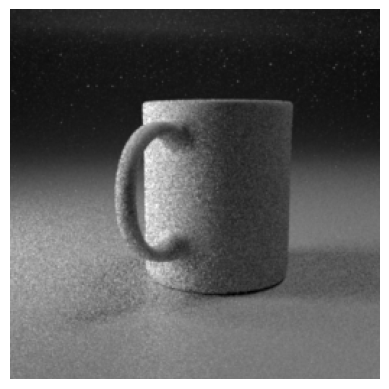

In [4]:
hparams = {'resx': 256,
            'resy': 256,
            'nsamples': 1,
            'sigma': 0.1,
            'render_spp': 32,
            'initial_translation': [9],
            'gt_translation': [0],
            'integrator': 'path',
            'max_depth': 6,
            'reparam_max_depth': 2}

scene, params, mat_id, initial_vertex_positions = setup_coffecup_scene(hparams) # rotation

ctx_args = {'scene': scene, 'params': params, 'spp': hparams['render_spp'],                     # rendering
            'init_vpos': initial_vertex_positions, 'mat_id': mat_id, #'update_fn': update_fn,    # rendering
            'sampler': 'importance', 'antithetic': True, 'nsamples': hparams['nsamples'],       # ours
            'sigma': hparams['sigma'], 'device': device}  

# gt_rot = torch.rand((1,)).to(device) * 9
# gt_color = torch.rand((3,)).to(device)

# generate input image
# reference_image = get_mts_rendering(gt_rot, update_fn, ctx_args)
# reference_image = get_mts_rendering(gt_color, apply_color, ctx_args)

def gen_data(gt_param=None, mitsuba=False, device='cuda'):
    '''
    generate gt data and reference image
    '''
    # gt_color = torch.rand((1,3)).to(device)
    if gt_param is None:
        gt_param = torch.rand((1,)).to(device) * 5 + 7
    # reference_image = get_mts_rendering(gt_color, apply_color, ctx_args)
    if mitsuba:
        reference_image = get_mts_rendering_mts(gt_param, apply_rotation, ctx_args)
    else:
        reference_image = get_mts_rendering(gt_param, apply_rotation, ctx_args)
        reference_image = reference_image.permute(2, 0, 1)
    return gt_param, reference_image


# gt_color, reference_image = gen_data()
# print(f'Color is {gt_color}')
# reference_image = image_for_plotting(reference_image)
# plt.imshow(reference_image)
# plt.axis('off')
# plt.show()
gt_rot, reference_image = gen_data()
print(f'rot is {gt_rot}')
reference_image = image_for_plotting(reference_image)
plt.imshow(reference_image)
plt.axis('off')
plt.show()
    

# CNN

In [5]:
class CNN(nn.Module):
    def __init__(self, n_params):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
        self.fc1 = nn.Linear(16 * 8 * 8, 256)  # Assuming input image size is 256x256
        self.fc2 = nn.Linear(256, n_params)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = x.view(-1, 16*8*8)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc2(x)
        return x

# Train with encoder only (not useful for unknown training parameters)

In [148]:
n_params = 3  # Number of output parameters
model = CNN(n_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {pytorch_total_params}')
criterion = nn.MSELoss()
model.to(device)

# optimization - encoder only
max_step = 5000
for i in range(max_step):
    gt_color, input_image = gen_data()
    output_color = model(input_image)

    loss = criterion(output_color, gt_color)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Loss at step {i}: {loss.item()}')
    if loss.item() < 1e-5:
        print(f'Converged at step {i}')
        break


Total number of parameters: 268259
Loss at step 0: 106.872802734375


/root/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss at step 100: 0.10960056632757187


KeyboardInterrupt: 

Final loss: 4.754169822263066e-06
GT color: tensor([[0.7860, 0.2936, 0.2092]], device='cuda:0')
Output color: tensor([[0.7832, 0.3062, 0.1735]], device='cuda:0', grad_fn=<AddmmBackward0>)


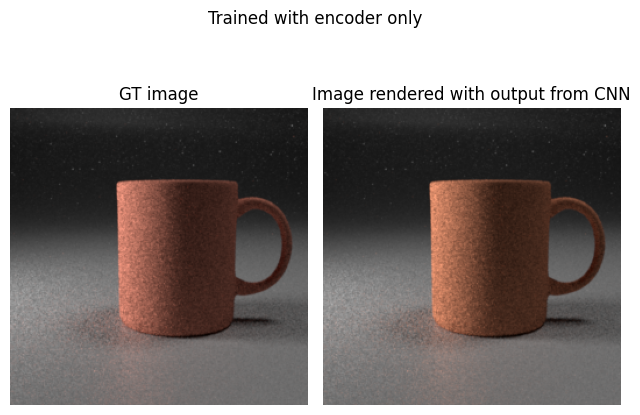

In [13]:
print("Final loss:", loss.item())
test_color, test_image = gen_data()
output_color = model(test_image)
gt_image = image_for_plotting(test_image)
output_image = image_for_plotting(get_mts_rendering(output_color, apply_color, ctx_args))
print(f'GT color: {test_color}')
print(f'Output color: {output_color}')
plt.subplot(1, 2, 1)
plt.imshow(gt_image)
plt.title('GT image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Image rendered with output from CNN')
plt.axis('off')
plt.suptitle('Trained with encoder only')
plt.tight_layout()
plt.show()

# Mitsuba as decoder

In [48]:
update_fn = apply_rotation_mts
ctx_args = {'scene': scene, 'params': params, 'spp': hparams['render_spp'],                     # rendering
            'init_vpos': initial_vertex_positions, 'mat_id': mat_id, 'update_fn': update_fn,    # rendering
            'sampler': 'importance', 'antithetic': True, 'nsamples': hparams['nsamples'],       # ours
            'sigma': hparams['sigma'], 'device': device}  

In [49]:
def mitsuba_grad(gt_image, output_param):
    # out_param = dr.cuda.ad.Float(output_param.item()) if isinstance(gt_param, (int, float)) else dr.cuda.ad.TensorXf(output_param.reshape(gt_shape))
    out_param = dr.cuda.ad.Float(output_param.item()) 
    dr.enable_grad(out_param)
    update_fn(out_param, p=ctx_args['params'], init_vpos=ctx_args['init_vpos'], mat_id=ctx_args['mat_id'])
    rendering = mi.render(ctx_args['scene'], ctx_args['params'], seed=0, spp=ctx_args['spp'])

    cur_img_loss = dr.mean((rendering - gt_image)**2) 
    dr.backward(cur_img_loss)

    return dr.grad(out_param)

In [51]:
n_params = 1
model = CNN(n_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()    
model.to(device)

max_step = 100
sample_per_step = 100
func_loss_traj, param_loss_traj, iter_times = [], [], []
for i in range(max_step):
    start_time = time.time()
    param_loss = torch.zeros(sample_per_step)
    func_loss = torch.zeros(sample_per_step)
    for j in range(sample_per_step):
        gt_param, input_image = gen_data(mitsuba=True)
        gt_shape = gt_param.shape
        input_image_torch = torch.tensor(input_image, dtype=torch.float32, device=ctx_args['device']).permute(2, 0, 1)
        ctx_args['gt_image'] = input_image_torch.permute(1, 2, 0) 
        output_param = model(input_image_torch)*18
        output_shape = output_param.shape
        # ours
        grad = mitsuba_grad(input_image, output_param)
        grad = torch.tensor(grad, dtype=torch.float32, device=ctx_args['device']).reshape(output_shape)
        optimizer.zero_grad()
        output_param.backward(gradient=grad)
        # print(grad)
        gt_param = torch.as_tensor(gt_param, device=device).reshape(output_param.shape)
        param_loss[j] = criterion(output_param, gt_param)
        out_param = output_param.item() if isinstance(gt_param, (int, float)) else output_param.reshape(gt_shape)
        func_loss[j] = criterion(ctx_args['gt_image'], get_mts_rendering(out_param, update_fn, ctx_args))
        optimizer.step()

    mean_param_loss = param_loss.mean()
    mean_func_loss = func_loss.mean()
    time_taken = time.time() - start_time
    print(f'At step {i}')
    print(f'\t parameter loss: {mean_param_loss.item()}')
    print(f'\t function loss: {mean_func_loss.item()}')
    print(f'\t time: {time_taken}')
    func_loss_traj.append(mean_func_loss.item())
    param_loss_traj.append(mean_param_loss.item())
    iter_times.append(time_taken)
    
    if mean_param_loss.item() < 1e-5:
        print(f'Converged at step {i}')
        break


np.save(f'./results/CNN_mug/CNN_mug_mitsuba/CNN_mug_mitsuba_f_loss.npy', func_loss_traj)
np.save(f'./results/CNN_mug/CNN_mug_mitsuba/CNN_mug_mitsuba_param_loss.npy', param_loss_traj)
np.save(f'./results/CNN_mug/CNN_mug_mitsuba/CNN_mug_mitsuba_times.npy', iter_times)

At step 0
	 parameter loss: 1.9960078001022339
	 function loss: 0.00354156456887722
	 time: 93.77715420722961
At step 1
	 parameter loss: 1.9033011198043823
	 function loss: 0.003736495040357113
	 time: 25.865761756896973
At step 2
	 parameter loss: 2.2365365028381348
	 function loss: 0.003727312432602048
	 time: 26.14507293701172
At step 3
	 parameter loss: 2.1886987686157227
	 function loss: 0.003979927394539118
	 time: 25.64502263069153
At step 4
	 parameter loss: 1.8532512187957764
	 function loss: 0.0035351798869669437
	 time: 25.83008313179016
At step 5
	 parameter loss: 2.067700147628784
	 function loss: 0.0034241408575326204
	 time: 25.78134560585022
At step 6
	 parameter loss: 2.3647544384002686
	 function loss: 0.0037646882701665163
	 time: 25.46396827697754
At step 7
	 parameter loss: 2.1224887371063232
	 function loss: 0.003710654331371188
	 time: 25.967758417129517
At step 8
	 parameter loss: 1.7323734760284424
	 function loss: 0.0033607047516852617
	 time: 25.850379705429

In [53]:
n_params = 1
torch.save(model.state_dict(), './results/CNN_mug/CNN_mug_mitsuba/CNN_mug_mitsuba_weights.pth')
model = CNN(n_params)
model.load_state_dict(torch.load('./results/CNN_mug/CNN_mug_mitsuba/CNN_mug_mitsuba_weights.pth', weights_only=True))
model.eval()
model.to(device)

/root/miniconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

GT param: tensor([10.9661], device='cuda:0')
Output param: tensor([9.7490], device='cuda:0', grad_fn=<ViewBackward0>)


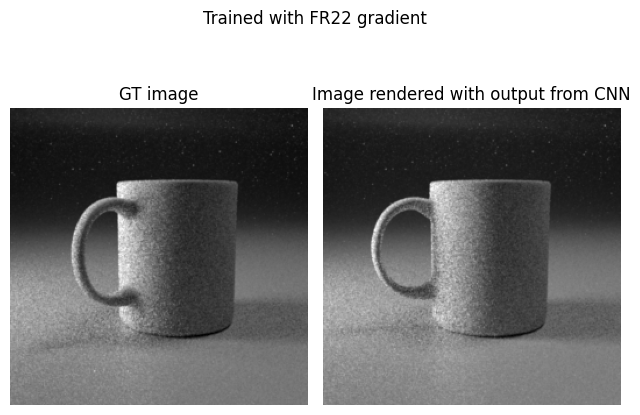

In [58]:
test_param, test_image = gen_data()
output_param = model(test_image)*18
gt_image = image_for_plotting(test_image)
output_param = output_param.item() if isinstance(test_param, (int, float)) else output_param.reshape(test_param.shape)
output_image = image_for_plotting(get_mts_rendering(output_param, update_fn, ctx_args))
print(f'GT param: {test_param}')
print(f'Output param: {output_param}')
    
plt.subplot(1, 2, 1)
plt.imshow(gt_image)
plt.title('GT image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Image rendered with output from CNN')
plt.axis('off')
plt.suptitle('Trained with FR22 gradient')
plt.tight_layout()
plt.show()

# Add FR22 as decoder

## Setup

In [43]:
update_fn = apply_rotation
hparams['sigma'] = 0.5
ctx_args = {'scene': scene, 'params': params, 'spp': hparams['render_spp'],                     # rendering
            'init_vpos': initial_vertex_positions, 'mat_id': mat_id, 'update_fn': update_fn,    # rendering
            'sampler': 'importance', 'antithetic': True, 'nsamples': hparams['nsamples'],       # ours
            'sigma': hparams['sigma'], 'device': device}  

f_args = {'update_fn': update_fn, 'ctx_args': ctx_args}
kernel_args = {'sigma': hparams['sigma']}
sampler_args = {'sigma': hparams['sigma'], 'is_antithetic': ctx_args['antithetic'], 'dir':(0,0)}

## Training

In [44]:
# optimization - with FR22 as decoder
n_params = 1  # Number of output parameters
model = CNN(n_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
model.to(device)

diff_func = smoothFn_gradient_mi(func=render_smooth, n=ctx_args['nsamples'], f_args=f_args,
                        kernel_args=kernel_args, sampler_args=sampler_args, device=device)# optimization - with FR22 as decoder

max_step = 100
sample_per_step = 100
func_loss_traj, param_loss_traj, iter_times = [], [], []
for i in range(max_step):
    start_time = time.time()
    param_loss = torch.zeros(sample_per_step)
    func_loss = torch.zeros(sample_per_step)
    for j in range(sample_per_step):
        gt_param, input_image = gen_data()
        gt_shape = gt_param.shape
        output_param = model(input_image)*18
        # ours
        ctx_args['gt_image'] = input_image.permute(1, 2, 0) 
        grad = diff_func(output_param)
        print(grad)
        optimizer.zero_grad()
        output_param.backward(gradient=grad)
        # print(grad)
        gt_param = torch.as_tensor(gt_param, device=device).reshape(output_param.shape)
        param_loss[j] = criterion(output_param, gt_param)
        out_param = output_param.item() if isinstance(gt_param, (int, float)) else output_param.reshape(gt_shape)
        func_loss[j] = criterion(ctx_args['gt_image'], get_mts_rendering(out_param, update_fn, ctx_args))
        optimizer.step()

    mean_param_loss = param_loss.mean()
    mean_func_loss = func_loss.mean()
    time_taken = time.time() - start_time
    print(f'At step {i}')
    print(f'\t parameter loss: {mean_param_loss.item()}')
    print(f'\t function loss: {mean_func_loss.item()}')
    print(f'\t time: {time_taken}')
    func_loss_traj.append(mean_func_loss.item())
    param_loss_traj.append(mean_param_loss.item())
    iter_times.append(time_taken)
    
    if mean_param_loss.item() < 1e-5:
        print(f'Converged at step {i}')
        break


np.save(f'./results/CNN_mug/CNN_mug_FR22/CNN_mug_FR22_f_loss.npy', func_loss_traj)
np.save(f'./results/CNN_mug/CNN_mug_FR22/CNN_mug_FR22_param_loss.npy', param_loss_traj)
np.save(f'./results/CNN_mug/CNN_mug_FR22/CNN_mug_FR22_times.npy', iter_times)



tensor([[-0.0026]], device='cuda:0')
tensor([[0.0013]], device='cuda:0')
tensor([[-9.6445e-05]], device='cuda:0')
tensor([[0.0021]], device='cuda:0')
tensor([[0.0037]], device='cuda:0')
tensor([[-0.0002]], device='cuda:0')
tensor([[-3.7826e-06]], device='cuda:0')
tensor([[-0.0015]], device='cuda:0')
tensor([[-0.0002]], device='cuda:0')
tensor([[0.0002]], device='cuda:0')
tensor([[0.0034]], device='cuda:0')
tensor([[-0.0002]], device='cuda:0')
tensor([[0.0003]], device='cuda:0')
tensor([[-0.0004]], device='cuda:0')
tensor([[0.0007]], device='cuda:0')
tensor([[-0.0008]], device='cuda:0')
tensor([[0.0026]], device='cuda:0')
tensor([[0.0011]], device='cuda:0')
tensor([[-0.0004]], device='cuda:0')
tensor([[-0.0015]], device='cuda:0')
tensor([[0.0028]], device='cuda:0')


KeyboardInterrupt: 

In [14]:
n_params = 1
# torch.save(model.state_dict(), './results/CNN_mug/CNN_mug_FR22/CNN_mug_FR22_weights.pth')
model = CNN(n_params)
model.load_state_dict(torch.load('./results/CNN_mug/CNN_mug_FR22/CNN_mug_FR22_weights.pth', weights_only=True))
model.eval()
model.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

GT param: tensor([7.9199], device='cuda:0')
Output param: tensor([7.5531], device='cuda:0', grad_fn=<ViewBackward0>)


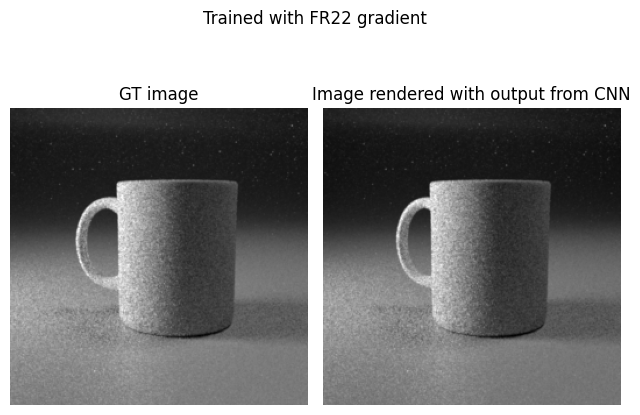

In [15]:
test_param, test_image = gen_data()
output_param = model(test_image)*18
gt_image = image_for_plotting(test_image)
output_param = output_param.item() if isinstance(test_param, (int, float)) else output_param.reshape(test_param.shape)
output_image = image_for_plotting(get_mts_rendering(output_param, update_fn, ctx_args))
print(f'GT param: {test_param}')
print(f'Output param: {output_param}')
    
plt.subplot(1, 2, 1)
plt.imshow(gt_image)
plt.title('GT image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Image rendered with output from CNN')
plt.axis('off')
plt.suptitle('Trained with FR22 gradient')
plt.tight_layout()
plt.show()

# Add Our G as decoder

## Setup

In [16]:
update_fn = apply_rotation
hparams['sigma'] = 0.5
ctx_args = {'scene': scene, 'params': params, 'spp': hparams['render_spp'],                     # rendering
            'init_vpos': initial_vertex_positions, 'mat_id': mat_id, 'update_fn': update_fn,    # rendering
            'sampler': 'importance', 'antithetic': True, 'nsamples': hparams['nsamples'],       # ours
            'sigma': hparams['sigma'], 'device': device}  

f_args = {'update_fn': update_fn, 'ctx_args': ctx_args}
kernel_args = {'sigma': hparams['sigma']}
sampler_args = {'sigma': hparams['sigma'], 'is_antithetic': ctx_args['antithetic'], 'dir':(0,0)}

## Training

In [52]:
# optimization - with ours G as decoder
n_params = 1  # Number of output parameters
model = CNN(n_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
model.to(device)

diff_func = smoothFn_gradient(func=render_smooth, sampler='importance_gradgauss', n=ctx_args['nsamples'], f_args=f_args,
                        kernel_args=kernel_args, sampler_args=sampler_args, device=device)
max_step = 100
sample_per_step = 100
func_loss_traj, param_loss_traj, iter_times = [], [], []
for i in range(max_step):
    start_time = time.time()
    param_loss = torch.zeros(sample_per_step)
    func_loss = torch.zeros(sample_per_step)
    for j in range(sample_per_step):
        gt_param, input_image = gen_data()
        gt_shape = gt_param.shape
        output_param = model(input_image)*18
        # ours
        ctx_args['gt_image'] = input_image.permute(1, 2, 0) 
        grad = diff_func(output_param)
        optimizer.zero_grad()
        output_param.backward(gradient=grad)
        # print(grad)
        gt_param = torch.as_tensor(gt_param, device=device).reshape(output_param.shape)
        param_loss[j] = criterion(output_param, gt_param)
        out_param = output_param.item() if isinstance(gt_param, (int, float)) else torch.reshape(output_param, gt_shape)
        func_loss[j] = criterion(ctx_args['gt_image'], get_mts_rendering(out_param, update_fn, ctx_args))
        optimizer.step()

    mean_param_loss = param_loss.mean()
    mean_func_loss = func_loss.mean()
    time_taken = time.time() - start_time
    print(f'At step {i}')
    print(f'\t parameter loss: {mean_param_loss.item()}')
    print(f'\t function loss: {mean_func_loss.item()}')
    print(f'\t time: {time_taken}')
    func_loss_traj.append(mean_func_loss.item())
    param_loss_traj.append(mean_param_loss.item())
    iter_times.append(time_taken)
    
    if mean_param_loss.item() < 1e-5:
        print(f'Converged at step {i}')
        break


np.save(f'./results/CNN_mug/CNN_mug_G/CNN_mug_G_f_loss.npy', func_loss_traj)
np.save(f'./results/CNN_mug/CNN_mug_G/CNN_mug_G_param_loss.npy', param_loss_traj)
np.save(f'./results/CNN_mug/CNN_mug_G/CNN_mug_G_times.npy', iter_times)


At step 0
	 parameter loss: 2.092931032180786
	 function loss: 0.0032543453853577375
	 time: 19.4920015335083
At step 1
	 parameter loss: 2.108203172683716
	 function loss: 0.0032697301357984543
	 time: 19.3592848777771
At step 2
	 parameter loss: 2.246893882751465
	 function loss: 0.0032518731895834208
	 time: 19.696187019348145
At step 3
	 parameter loss: 2.0027880668640137
	 function loss: 0.0031882477924227715
	 time: 19.496530532836914
At step 4
	 parameter loss: 1.5871227979660034
	 function loss: 0.0025258809328079224
	 time: 19.769702672958374
At step 5
	 parameter loss: 1.1569421291351318
	 function loss: 0.002289967145770788
	 time: 19.482131242752075
At step 6
	 parameter loss: 0.8410292267799377
	 function loss: 0.002124316990375519
	 time: 19.709115743637085
At step 7
	 parameter loss: 0.5452018976211548
	 function loss: 0.0015425254823639989
	 time: 19.74815034866333
At step 8
	 parameter loss: 0.40858444571495056
	 function loss: 0.001822703517973423
	 time: 19.887103796

In [17]:
n_params = 1
# torch.save(model.state_dict(), './results/CNN_mug/CNN_mug_G/CNN_mug_G_weights.pth')
model = CNN(n_params)
model.load_state_dict(torch.load('./results/CNN_mug/CNN_mug_G/CNN_mug_G_weights.pth', weights_only=True))
model.eval()
model.to(device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

GT color: tensor([11.8941], device='cuda:0')
Output color: tensor([11.7041], device='cuda:0', grad_fn=<ViewBackward0>)


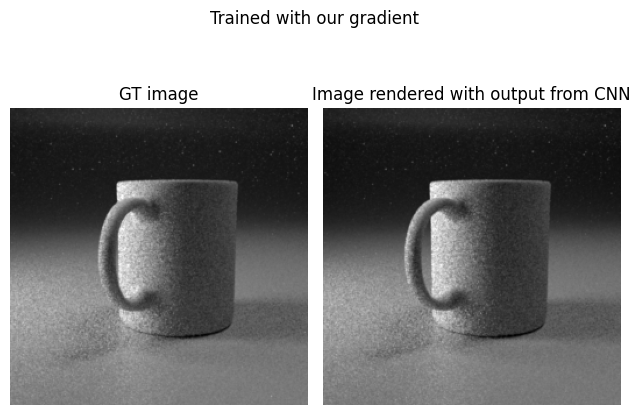

In [24]:
test_param, test_image = gen_data()

output_param = model(test_image)*18
gt_image = image_for_plotting(test_image)

output_param = output_param.item() if isinstance(test_param, (int, float)) else output_param.reshape(test_param.shape)
output_image = image_for_plotting(get_mts_rendering(output_param, update_fn, ctx_args))
print(f'GT color: {test_param}')
print(f'Output color: {output_param}')
plt.subplot(1, 2, 1)
plt.imshow(gt_image)
plt.title('GT image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Image rendered with output from CNN')
plt.axis('off')
plt.suptitle('Trained with our gradient')
plt.tight_layout()
plt.show()

# Our H

## Setup

In [7]:
update_fn = apply_rotation
hparams['sigma'] = 0.5
ctx_args = {'scene': scene, 'params': params, 'spp': hparams['render_spp'],                     # rendering
            'init_vpos': initial_vertex_positions, 'mat_id': mat_id, 'update_fn': update_fn,    # rendering
            'sampler': 'importance', 'antithetic': True, 'nsamples': hparams['nsamples'],       # ours
            'sigma': hparams['sigma'], 'device': device}  

f_args = {'update_fn': update_fn, 'ctx_args': ctx_args}
kernel_args = {'sigma': hparams['sigma']}
sampler_args = {'sigma': hparams['sigma'], 'is_antithetic': ctx_args['antithetic'], 'dir':(0,0)}

In [7]:
def jvp_model(model, x, v):
    '''
    JVP of model output wrt weights
    '''
    func, weights = functorch.make_functional(model)
    return torch.func.jvp(func, (weights, x), (v, torch.zeros_like(x)))[1]

n_params = 1  # Number of output parameters
model = CNN(n_params)
print(jvp_model(model, torch.rand((3, 256, 256)).to(device), torch.rand((1,)).to(device)).shape)

/root/miniconda3/lib/python3.10/site-packages/torch/_functorch/deprecated.py:100: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


RuntimeError: jvp(f, primals, tangents): Expected primals and tangents to have the same python structure. For example, if primals is a tuple of 3 tensors, tangents also must be. Got primals with structure TreeSpec(tuple, None, [TreeSpec(tuple, None, [*,
    *,
    *,
    *,
    *,
    *,
    *,
    *,
    *,
    *]),
  *]) and tangents with structure TreeSpec(tuple, None, [*,
  *])

In [10]:
# optimization - with ours G as decoder
n_params = 1  # Number of output parameters
model = CNN(n_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
model.to(device)


diff_func = smoothFn_gradient(func=render_smooth, sampler='importance_gradgauss', n=ctx_args['nsamples'], f_args=f_args,
                        kernel_args=kernel_args, sampler_args=sampler_args, device=device)
hess_f_func = smoothFn_hessian(func=render_smooth, sampler='importance_hessgauss', n=ctx_args['nsamples'], f_args=f_args,
                                kernel_args=kernel_args, sampler_args=sampler_args, device=device)
jac_func = torch.func.jacrev(model)


NR_max_iter = 20
NR_tol = 1e-3
recompute = 20
n_samples = ctx_args['nsamples']
TR = False
TR_bound = 10



max_step = 100
sample_per_step = 100
func_loss_traj, param_loss_traj, iter_times = [], [], []
for i in range(max_step):
    start_time = time.time()
    param_loss = torch.zeros(sample_per_step)
    func_loss = torch.zeros(sample_per_step)
    
    for j in range(sample_per_step):
        gt_param, input_image = gen_data()
        gt_shape = gt_param.shape
        output_param = model(input_image)*18
        # ours
        ctx_args['gt_image'] = input_image.permute(1, 2, 0) 
        hess = hess_f_func(output_param)
        # grad = diff_func(output_param)
        print(f'hessian: {hess}, gradient: {grad}')
        optimizer.zero_grad()
        output_param.backward(gradient=grad)
        # print(grad)
        gt_param = torch.as_tensor(gt_param, device=device).reshape(output_param.shape)
        param_loss[j] = criterion(output_param, gt_param)
        out_param = output_param.item() if isinstance(gt_param, (int, float)) else torch.reshape(output_param, gt_shape)
        func_loss[j] = criterion(ctx_args['gt_image'], get_mts_rendering(out_param, update_fn, ctx_args))
        optimizer.step()
        
        
        for k in range(NR_max_iter): # newton-ralphson iterative approximation
            hvp = hess_func(x)@d
            # print('full: ', hess_func(x)@d)
            denom = d.T@hvp
            if denom <= 0:
                denom = 1
            alpha = -(diff_func(x)@d / denom).item()
            step = alpha*d.squeeze()
            if step.norm() > TR_bound and TR:
                step = step/step.norm()*TR_bound
            x = x + step
            if alpha**2 * delta_d <= NR_tol:
                break
            
    mean_param_loss = param_loss.mean()
    mean_func_loss = func_loss.mean()
    time_taken = time.time() - start_time
    print(f'At step {i}')
    print(f'\t parameter loss: {mean_param_loss.item()}')
    print(f'\t function loss: {mean_func_loss.item()}')
    print(f'\t time: {time_taken}')
    func_loss_traj.append(mean_func_loss.item())
    param_loss_traj.append(mean_param_loss.item())
    iter_times.append(time_taken)
    
    if mean_param_loss.item() < 1e-5:
        print(f'Converged at step {i}')
        break


np.save(f'./results/CNN_mug/CNN_mug_G/CNN_mug_G_f_loss.npy', func_loss_traj)
np.save(f'./results/CNN_mug/CNN_mug_G/CNN_mug_G_param_loss.npy', param_loss_traj)
np.save(f'./results/CNN_mug/CNN_mug_G/CNN_mug_G_times.npy', iter_times)


<generator object Module.parameters at 0x7fa1342d7b50>
hessian: tensor([[-0.0034]], device='cuda:0'), gradient: tensor([[-0.0011]], device='cuda:0')
hessian: tensor([[0.0162]], device='cuda:0'), gradient: tensor([[0.0004]], device='cuda:0')
hessian: tensor([[0.0119]], device='cuda:0'), gradient: tensor([[-0.0029]], device='cuda:0')
hessian: tensor([[-0.0090]], device='cuda:0'), gradient: tensor([[-0.0033]], device='cuda:0')
hessian: tensor([[-0.0201]], device='cuda:0'), gradient: tensor([[-4.0808e-05]], device='cuda:0')
hessian: tensor([[-0.0131]], device='cuda:0'), gradient: tensor([[-0.0030]], device='cuda:0')
hessian: tensor([[0.0116]], device='cuda:0'), gradient: tensor([[0.0033]], device='cuda:0')
hessian: tensor([[0.0202]], device='cuda:0'), gradient: tensor([[-0.0012]], device='cuda:0')
hessian: tensor([[-0.0198]], device='cuda:0'), gradient: tensor([[-0.0014]], device='cuda:0')
hessian: tensor([[-0.0111]], device='cuda:0'), gradient: tensor([[0.0034]], device='cuda:0')
hessian:

KeyboardInterrupt: 

# Our HVP

In [8]:
# setup second order   
n_params = 1  # Number of output parameters
model = CNN(n_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
model.to(device)
params = dict(model.named_parameters())
print(params)

{'conv1.weight': Parameter containing:
tensor([[[[ 3.6287e-02,  1.5870e-02,  3.4415e-02],
          [ 3.5369e-02, -7.8304e-02, -7.7137e-02],
          [ 1.1307e-01, -1.1702e-01, -1.7604e-01]],

         [[ 1.3268e-01,  6.9870e-02,  1.0162e-02],
          [-1.3114e-01, -1.8621e-01,  5.4116e-02],
          [ 1.9236e-02,  1.1104e-02, -1.5842e-01]],

         [[-1.9133e-01,  7.8844e-02,  4.1155e-03],
          [ 5.3940e-02,  1.0604e-01, -1.5717e-01],
          [-1.2711e-01,  9.4415e-02, -7.3201e-04]]],


        [[[-3.0183e-02, -1.3903e-01,  4.1759e-02],
          [ 1.6282e-01,  1.8133e-01,  1.7574e-01],
          [ 9.0277e-02, -2.0499e-02,  1.3427e-01]],

         [[ 6.5758e-02,  2.0640e-02, -1.3146e-01],
          [ 6.3648e-02, -1.1733e-01,  6.5286e-02],
          [-1.2002e-01,  5.3429e-02, -5.3444e-02]],

         [[ 1.5296e-02,  3.4754e-02, -1.2697e-01],
          [-1.4581e-02,  5.1096e-02, -1.0708e-01],
          [-9.0023e-02, -1.0897e-01,  9.5244e-02]]],


        [[[ 6.9452e-02,  1.

# Plotting

FR22 time traj: [  19.49200153   40.73062682   61.9692521    83.20787739  104.44650268
  125.68512796  146.92375325  168.16237853  189.40100382  210.6396291
  231.87825439  253.11687968  274.35550496  295.59413025  316.83275553
  338.07138082  359.3100061   380.54863139  401.78725667  423.02588196
  444.26450725  465.50313253  486.74175782  507.9803831   529.21900839
  550.45763367  571.69625896  592.93488424  614.17350953  635.41213482
  656.6507601   677.88938539  699.12801067  720.36663596  741.60526124
  762.84388653  784.08251182  805.3211371   826.55976239  847.79838767
  869.03701296  890.27563824  911.51426353  932.75288881  953.9915141
  975.23013939  996.46876467 1017.70738996 1038.94601524 1060.18464053
 1081.42326581 1102.6618911  1123.90051638 1145.13914167 1166.37776696
 1187.61639224 1208.85501753 1230.09364281 1251.3322681  1272.57089338
 1293.80951867 1315.04814396 1336.28676924 1357.52539453 1378.76401981
 1400.0026451  1421.24127038 1442.47989567 1463.71852095 1484.9

Text(0.5, 1.0, 'CNN training trajectory')

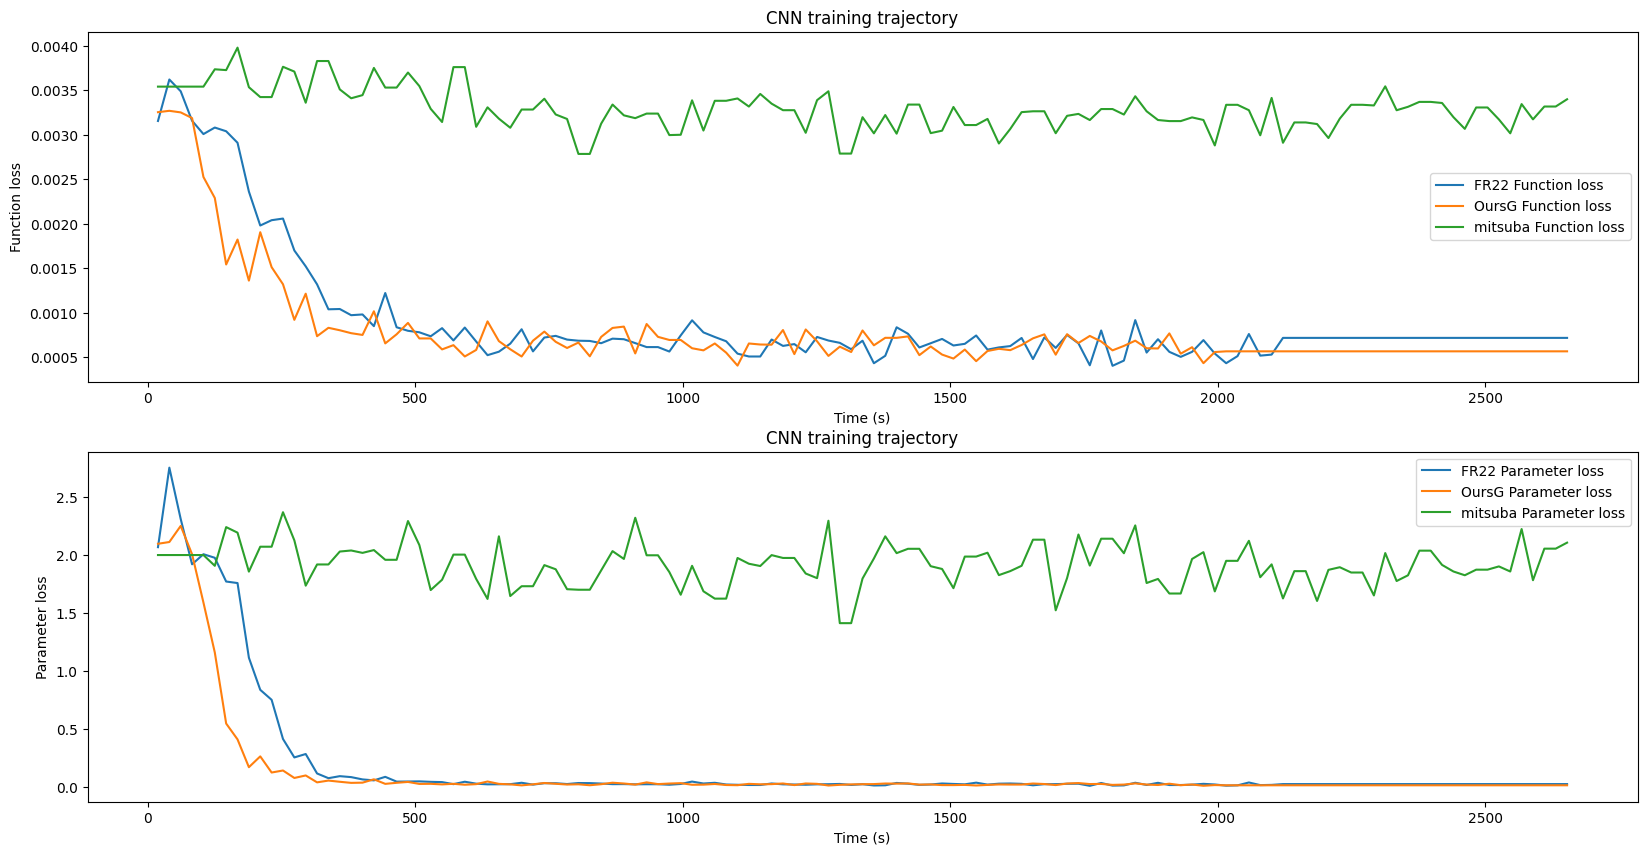

In [59]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
task = 'CNN_mug'
path = './results/' + task + '/'
opts = ['FR22', 'G', 'mitsuba']#, 'cg', 'cg_HVP']
opt_names = ['FR22', 'OursG', 'mitsuba']#, 'CG', 'CGHVP']

def round_to_nearest(times, new_times):
    return np.argmin(np.abs(new_times - times))

dataset = []
for i in range(len(opts)):
    iter_times = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_times.npy')
    f_loss = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_f_loss.npy')
    param_loss = np.load(path + task + '_' + opts[i] + '/' + task + '_' + opts[i] + f'_param_loss.npy')
    dataset.append({'times': np.cumsum(iter_times), 'f_loss': f_loss, 'param_loss': param_loss})

all_times = np.concatenate([d['times'] for d in dataset])
global_start, global_end = np.min(all_times), np.max(all_times)
smallest_set = min(dataset, key=lambda x: len(x['times']))
smallest_times = smallest_set['times']
average_iter_time = np.mean(np.diff(smallest_times))
new_timestamps = np.arange(global_start, global_end+average_iter_time, average_iter_time)

new_dataset = []
for i, data in enumerate(dataset):
    times = data['times']
    # rounded_times = np.unique(rounded_times)
    f_loss_rounded = []
    param_loss_rounded = []
    f_loss_orig = data['f_loss']
    for j, t in enumerate(new_timestamps):
        # print(t)
        # print(times[-1])
        # if t >= times[-1]:
        #     break
        nearest_idx = round_to_nearest(times, t)
        if nearest_idx >= len(f_loss_orig):
            break
        f_loss_rounded.append(f_loss_orig[nearest_idx])
        param_loss_rounded.append(data['param_loss'][nearest_idx])
    f_loss_rounded = np.array(f_loss_rounded)
    param_loss_rounded = abs(np.array(param_loss_rounded))
    new_dataset.append({'times': new_timestamps[:len(f_loss_rounded)], 'f_loss': f_loss_rounded, 'param_loss': param_loss_rounded})
    # new_dataset[[opts[j]]] = {'times': rounded_times, 'f_loss': f_loss_rounded, 'param_loss': param_loss_rounded}
    

for i in range(len(opts)):
    times = new_dataset[i]['times']
    f_loss = new_dataset[i]['f_loss']
    param_loss = new_dataset[i]['param_loss']
    label_prefix = opt_names[i]
        
    with np.printoptions(threshold=np.inf):
        print(f'{label_prefix} time traj: {times}')
        print(f'{label_prefix} f_loss traj: {f_loss}')
        print(f'{label_prefix} param_loss traj: {param_loss}')
        
    ax[0].plot(times, f_loss, label=label_prefix + ' Function loss')
    ax[1].plot(times, param_loss.squeeze(), label=label_prefix+' Parameter loss')
    
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Function loss')
ax[0].set_title(f'CNN training trajectory')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Parameter loss')
ax[1].set_title(f'CNN training trajectory')
# save_path = './results/' + task + '/' + task + '_task.pdf'
# plt.savefig(save_path, format='pdf')
# ax[0,0].set_yscale('log')
# ax[0,1].set_yscale('log')
# save_path = './results/' + task + '/' + task + '_task_log.pdf'
# plt.savefig(save_path, format='pdf') 